In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import exp, log, sqrt
from scipy.special import erf

In [8]:
def bsexact(sigma: float, R: float, K: float, T: float, s: float):
    d1 = (log(s/K)+(R+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    F = 0.5*s*(1+erf(d1/sqrt(2)))-exp(-R*T)*K*0.5*(1+erf(d2/sqrt(2)))
    return F

European Call Option Price: 0.4624
European Put Option Price: 0.7469


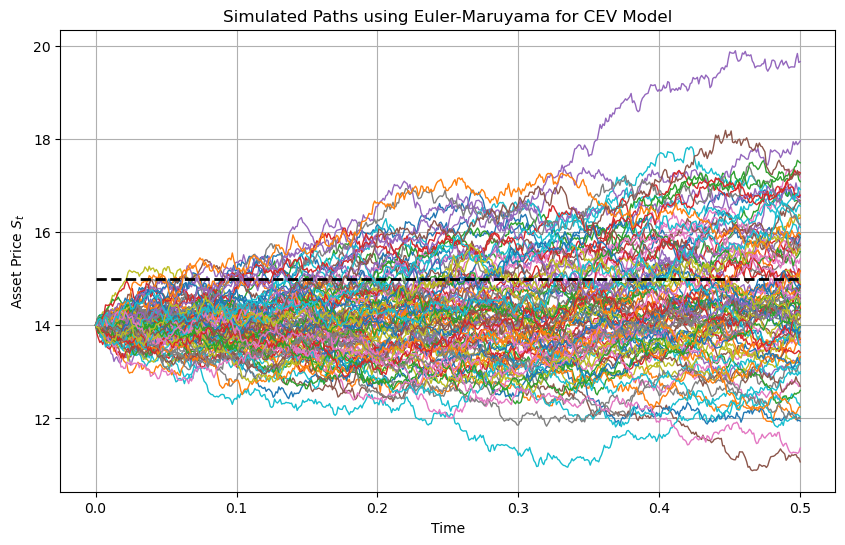

In [2]:
# Parameters for the CEV model
r = 0.1          # Risk-free rate
sigma = 0.25     # Volatility
gamma = 0.8      # Elasticity parameter (CEV parameter)
S0 = 14          # Initial value of the asset (e.g. stock price)
T = 0.5          # Time horizon
N = 500          # Number of time steps
dt = T / N       # Time step size
n_simulations = 100  # Number of simulation paths
K = 15           # Strike price of the option

# Generate random Brownian increments
dW = np.random.normal(0, np.sqrt(dt), (n_simulations, N))

# Initialize array to store the simulated paths
S = np.zeros((n_simulations, N + 1))
S[:, 0] = S0

# Euler-Maruyama method to simulate the paths
for i in range(N):
    S[:, i+1] = S[:, i] + r * S[:, i] * dt + sigma * S[:, i]**gamma * dW[:, i]

# Compute the payoff at maturity for each simulation path
payoffs_call = np.maximum(S[:, -1] - K, 0)
payoffs_put = np.maximum(K-S[:, -1], 0)

# Calculate the mean of the payoffs
mean_payoff_call = np.mean(payoffs_call)
mean_payoff_put = np.mean(payoffs_put)

# Calculate the standard deviation of the payoffs
std_payoff_call = np.std(payoffs_call)
std_payoff_put = np.std(payoffs_put)

# Discount the mean payoff to present value
call_option_price = np.exp(-r * T) * mean_payoff_call
put_option_price = np.exp(-r * T) * mean_payoff_put

# Output the call option price
print(f"European Call Option Price: {call_option_price:.4f}")
print(f"European Put Option Price: {put_option_price:.4f}")
# Plotting the simulated paths
plt.figure(figsize=(10, 6))
for j in range(n_simulations):
    plt.plot(np.linspace(0, T, N+1), S[j, :], lw=1)
# Plot the strike price
plt.plot([0, T], [K, K], 'k--', lw=2)
plt.title('Simulated Paths using Euler-Maruyama for CEV Model')
plt.xlabel('Time')
plt.ylabel('Asset Price $S_t$')
plt.grid(True)
plt.show()

100%|██████████| 500/500 [00:06<00:00, 79.58it/s]


[100, 1000, 10000, 100000]
[0.08207233482527472, 0.026389382322237094, 0.008363742416107474, 0.0026431364104531393]


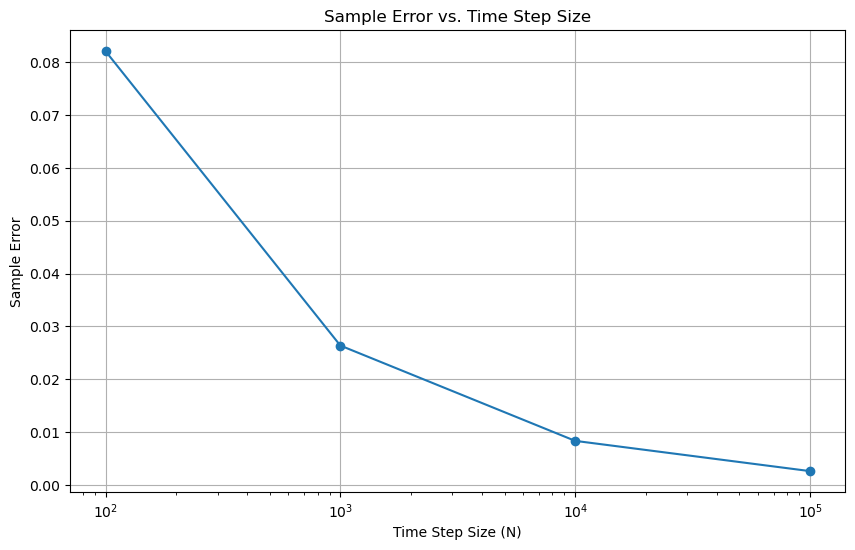

In [5]:
# Function to simulate the sample error with given number of simulations
def simulate_option_price(n_simulations):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    gamma = 0.8      # Elasticity parameter (CEV parameter)
    S0 = 14          # Initial value of the asset (e.g. stock price)
    T = 0.5          # Time horizon
    N = 500          # Number of time steps
    dt = T / N       # Time step size
    K = 15           # Strike price of the option

    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), (n_simulations, N))
    
    # Simulate paths
    S = np.zeros((n_simulations, N + 1))
    S[:, 0] = S0
    for i in tqdm(range(N)):
        S[:, i+1] = S[:, i] + r * S[:, i] * dt + sigma * S[:, i]**gamma * dW[:, i]
    
    # Compute the payoff at maturity
    payoffs = np.maximum(S[:, -1] - K, 0)
    
    # Estimate the sample error (standard deviation of the payoff)
    std_dev_payoffs = np.std(payoffs) ### OBS!! ### Should ths be payoff or the accual price of the option???? YES!
    sample_error = std_dev_payoffs / np.sqrt(n_simulations)
    
    return sample_error

# Run simulations with different time steps
n_values = [int(1e2), int(1e3), int(1e4), int(1e5)]
sample_errors = [simulate_option_price(n) for n in n_values]
print(n_values)
print(sample_errors)

# Plot the sample error as a function of the time step size mae x-axsis logaritmic
plt.figure(figsize=(10, 6))
plt.semilogx(n_values, sample_errors, 'o-')  # Use semilogx for logarithmic X-axis
plt.title('Sample Error vs. Time Step Size')
plt.xlabel('Time Step Size (N)')
plt.ylabel('Sample Error')
plt.grid(True)
plt.show()

# Output the prices for different time steps
#for N, sample_error in zip(N_values, sample_error):
#    print(f"Option Price with N = {N}: {sample_error:.4f}")


100%|██████████| 4000/4000 [00:00<00:00, 20285.27it/s]


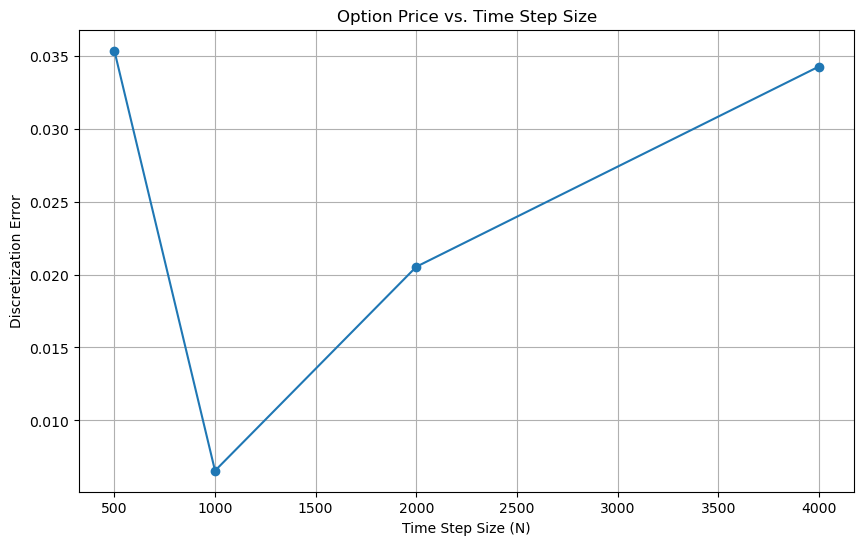

In [10]:
# Function to simulate the option price with given time steps (N)
def simulate_option_price(N):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    gamma = 1      # Elasticity parameter (CEV parameter)
    S0 = 14          # Initial value of the asset (e.g. stock price)
    T = 0.5          # Time horizon
    dt = T / N       # Time step size
    n_simulations = 1000  # Number of simulation paths
    K = 15           # Strike price of the option

    dt = T / N
    dW = np.random.normal(0, np.sqrt(dt), (n_simulations, N))
    
    # Simulate paths
    S = np.zeros((n_simulations, N + 1))
    S[:, 0] = S0
    for i in tqdm(range(N)):
        S[:, i+1] = S[:, i] + r * S[:, i] * dt + sigma * S[:, i]**gamma * dW[:, i]
    
    # Compute the payoff at maturity
    payoffs = np.maximum(S[:, -1] - K, 0)
    mean_payoff = np.mean(payoffs)
    call_option_price = np.exp(-r * T) * mean_payoff
    F = bsexact(sigma, r, K, T, S0)

    discretization_error = abs(call_option_price - F)
    return discretization_error

# Run simulations with different time steps
N_values = [500, 1000, 2000, 4000]
discretization_errors = [simulate_option_price(N) for N in N_values]

# Plot the option price as a function of the time step size
plt.figure(figsize=(10, 6))
plt.plot(N_values, discretization_errors, 'o-')
plt.title('Option Price vs. Time Step Size')
plt.xlabel('Time Step Size (N)')
plt.ylabel('Discretization Error')
plt.grid(True)
plt.show()